# Wellbeing Police

From various subreddit, we have scraped close to 4000 posts. The subreddits include "r/SuicideWatch", "r/BipolarReddit", "r/Anxiety", "r/AnxietyDepression", "r/Depression", and "r/Happy". Each of the subreddit posts currently sitting within its own csv file. We will see what are the fields that are consistent across the CSV files and choose those applicable. Clean up the data, removed the columns not needed. 

As all the scrapes was created from the same script, the columns of the resulting csv are same across the files. 
We will proceed to label them according to the subreddit they came from and combine them into a single dataframe.

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import pandas as pd
import numpy as np
import glob
import os
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Data Combination and Labeling

We retrieved posts in “Hot” section from various subreddits:
`r/ptsd`,`r/Anxiety`,`r/SuicideWatch`,`r/depression`,`r/BipolarReddit`,`r/schizophrenia`,`r/EDAnonymous`,`r/EatingDisorders`

In [3]:
path = "./reddit/csvs/"
all_csvs = glob.glob(os.path.join(path, "*.csv"))

all_dfs = []
for filename in all_csvs:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df[["title", "subreddit", "body"]]
    
    # ## manually remove irrelevant pinned posts
    # if df.iloc[0].subreddit in ["ptsd",'Anxiety',"SuicideWatch",'EDAnonymous']: 
    #     df=df[2:]
    # if df.iloc[0].subreddit in ['BipolarReddit','schizophrenia','EatingDisorders']:
    #     df=df[1:]
        
    all_dfs.append(df)

main_df = pd.concat(all_dfs)
print(main_df.shape)
main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df.head()


(20725, 3)
(18327, 3)


,title,subreddit,body
0,Self Help and Self Care Resources,ptsd,Unfortunately this is a small subreddit and as...
1,Survey thread,ptsd,If you have a survey you would like to share w...
2,"PTSD never getting better, don’t want to be al...",ptsd,Made a throwaway account for this obviously.\n...
3,I can’t be bothered with people anymore,ptsd,Why do I have to remind people all the time th...
4,I can't stop peeing my pants,ptsd,This is incredibly embarrassing but I am diagn...


A few of the subreddit is indicating the same underlying mental problems, we proceed to add an attribute such that these minor differentiation will be grouped for better and easier identification.

In [4]:
sub_problem_mapping = {
    "ptsd": "PTSD",
    "CPTSD": "PTSD",
    "Anxiety": "anxiety",
    "Anxietyhelp": "anxiety",
    "SuicideWatch": "suicidal",
    "selfharm": "suicidal",
    "depression": "depression",
    "depression_help": "depression", 
    "BipolarReddit": "bipolar", 
    "bipolar": "bipolar",
    "schizophrenia": "schizophrenia",
    "EDAnonymous": "eating disorder",
    "EatingDisorders": "eating disorder",

}

main_df["problem"] = [sub_problem_mapping[s] for s in main_df["subreddit"]]
main_df.head()

,title,subreddit,body,problem
0,Self Help and Self Care Resources,ptsd,Unfortunately this is a small subreddit and as...,PTSD
1,Survey thread,ptsd,If you have a survey you would like to share w...,PTSD
2,"PTSD never getting better, don’t want to be al...",ptsd,Made a throwaway account for this obviously.\n...,PTSD
3,I can’t be bothered with people anymore,ptsd,Why do I have to remind people all the time th...,PTSD
4,I can't stop peeing my pants,ptsd,This is incredibly embarrassing but I am diagn...,PTSD


### Text Cleaning and Processing
- Remove emoticons and non-text characters
- Remove excess newline and spacing characters added for emphasis (e.g., poetry paragraphing)
- Remove hyperlinks and tags
- Change text to lowercase
- Simplify punctuation by removing repeated characters (e.g., "?????", "!!!!")

In [5]:
from text_processing import text_processing

In [6]:
clean_text = text_processing()

clean_text.process_data(main_df, headers = ['title', 'subreddit', 'body'])

main_df.head()

,title,subreddit,body,problem
0,self help and self care resources,ptsd,unfortunately this is a small subreddit and as...,PTSD
1,survey thread,ptsd,if you have a survey you would like to share w...,PTSD
2,"ptsd never getting better, don’t want to be al...",ptsd,made a throwaway account for this obviously. i...,PTSD
3,i can’t be bothered with people anymore,ptsd,why do i have to remind people all the time th...,PTSD
4,i can't stop peeing my pants,ptsd,this is incredibly embarrassing but i am diagn...,PTSD


### Lemmatization with spaCy

We use spaCy to perform lemmatization.

In [7]:
nlp = spacy.load('en_core_web_sm')

## Apply further cleaning steps before tokenization
def normalize(text): 
    ## split list symbol with word e.g. -take 2,000mg fish oil
    text = re.sub(r"\s-([A-Za-z]+)\b",r" - \1", text, flags=0)
    
    ## further split number with word e.g., 6months, 28male, 2hrs
    text = re.sub(r"(\d+)([A-Za-z]+)",r"\1 \2", text, flags=0)
    return text
    
def lemmatize(text):
    doc = nlp(text)
    # Turn it into tokens, ignoring the punctuation
    tokens = [token for token in doc if not token.is_punct]
    # Convert those tokens into lemmas, EXCEPT the pronouns
    lemmas = [token.lemma_ if token.pos_ != 'PRON' else token.orth_ for token in tokens]
    return lemmas

In [8]:
## Apply normalize method
documents = main_df.body.apply(lambda text: normalize(text))
documents = documents.to_list()
# labels = main_df.problem.to_list() 


## Directly apply lemmatize function to documents to get tokenized text
# document_lemmatized = [lemmatize(post) for post in documents]
# document_lemmatized 

### Create Document-Term Matrices using TF-IDF Weights

In [9]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1')
#matrix = tfidf_vectorizer.fit_transform(documents)
#matrix

#tokens = tfidf_vectorizer.get_feature_names()

### KNN-Classification

#### Create Training & Test Set

To evaluate any classifier, we need to split our dataset into a training and a test set. With the method `train_test_split()` this is very easy to do; this method also shuffles the dataset by default, which is important for this example, since the dataset file is ordered with all positive sentences coming first. In the example below, we set the size of the test set to 20%.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline

from tqdm import tqdm

In [13]:
sentences = main_df.body
labels = main_df.problem
num_labels = len(labels.unique()) ##should be 7
print("Size of label/class : {}".format(num_labels))

# Split sentences and labels into training and test set with a test set size of 20%
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# We can directly convert the numerical class labels from lists to numpy arrays
y_train = np.asarray(labels_train)
y_test = np.asarray(labels_test)

print("Size of training set: {}".format(len(sentences_train)))
print("Size of test set: {}".format(len(sentences_test)))

Size of label/class : 7
Size of training set: 13663
Size of test set: 3416


In [15]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=20000)

X_train = tfidf_vectorizer.fit_transform(sentences_train)
X_test = tfidf_vectorizer.transform(sentences_test)

In [16]:
knn = KNeighborsClassifier(n_neighbors=num_labels).fit(X_train, y_train)

In [18]:
y_pred = knn.predict(X_test)

In [19]:
precision = metrics.precision_score(y_test, y_pred, average='micro')
recall = metrics.recall_score(y_test, y_pred, average='micro')
f1 = metrics.f1_score(y_test, y_pred, average='micro')

print("Precison: {:.3f}".format(precision))
print("Recall:   {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))
print(metrics.classification_report(y_test, y_pred))

Precison: 0.095
Recall:   0.095
F1 score: 0.095
                 precision    recall  f1-score   support

           PTSD       0.59      0.04      0.07       451
        anxiety       1.00      0.00      0.01       525
        bipolar       0.00      0.00      0.00       429
     depression       0.33      0.05      0.08       572
eating disorder       0.48      0.02      0.03       616
  schizophrenia       0.08      0.97      0.15       276
       suicidal       0.50      0.00      0.01       547

       accuracy                           0.10      3416
      macro avg       0.43      0.15      0.05      3416
   weighted avg       0.46      0.10      0.04      3416



In [22]:
k_sizes = [7]
#k_sizes = [7, 17, 27]

max_ngram_size = 1
#max_ngram_size = 3
num_k = len(k_sizes)

# Number runs = number traing/test a KNN classifier
num_runs = max_ngram_size * num_k

# numpy array to keep track of all results
knn_results = np.zeros((max_ngram_size, num_k))

with tqdm(total=num_runs) as pbar:
    for i, ngram in enumerate(range(1, max_ngram_size+1)):
        # Create Document-Term Matrix for different n-gram sizes
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngram), max_features=20000)
        X_train = tfidf_vectorizer.fit_transform(sentences_train)
        X_test = tfidf_vectorizer.transform(sentences_test)
        # Train & test model using cross validation
        for j, k in enumerate(k_sizes):
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn, X_train, y_train, cv=10, scoring="f1_micro")
            mean_score = np.mean(scores)
            knn_results[i,j] = mean_score
            pbar.update(1)

100%|████████████████████████████████████████████| 1/1 [03:30<00:00, 210.15s/it]


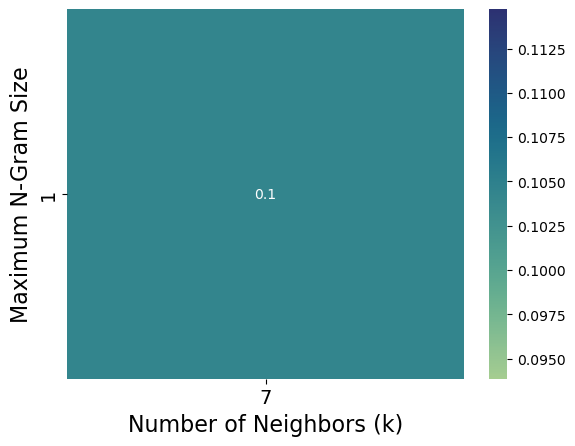

In [26]:
# Use the heatmap function from the seaborn package
plt.figure()

sns.heatmap(knn_results, annot=True, cmap="crest", xticklabels=k_sizes, yticklabels=list(range(1,max_ngram_size+1)))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Maximum N-Gram Size', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=16)

plt.show()